In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Source
 - https://docs.rapids.ai/api/cugraph/stable/installation/getting_cugraph/
 - https://snap.stanford.edu/data/#email
 - https://snap.stanford.edu/data/wiki-Talk.html

In [ ]:
# !wget https://snap.stanford.edu/data/CiscoSecureWorkload_22_networks.zip
# !unzip CiscoSecureWorkload_22_networks.zip

!wget https://snap.stanford.edu/data/wiki-Talk.txt.gz
!gunzip wiki-Talk.txt.gz  # Extract the file

In [ ]:
# !pip install arango
# !pip install cugraph
# !pip install networkx

!pip install cugraph--cu11 --extra-index-url=https://pypi.nvidia.com
!pip install networkx pyArango neo4j

In [ ]:
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install networkx py2neo langchain langgraph


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 20.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 187.6 MB/s eta 0:00:00
  Attempting uninstall: pylibcugraph-cu12
    Found existing installation: pylibcugraph-cu12 24.10.0
    Uninstalling pylibcugraph-cu12-24.10.0:
      Successfully uninstalled pylibcugraph-cu12-24.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.10.0 requires pylibcugraph-cu12==24.10.*, but you have pylibcugraph-cu12 25.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 4.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━

# # Graph into NetworkX

In [ ]:
import networkx as nx
import pandas as pd

df = pd.read_csv("wiki-Talk.txt", sep="\t", comment="#", names=["From", "To", "Timestamp"])

# Create a directed graph
G = nx.DiGraph()

# Add edges
G.add_edges_from(zip(df["From"], df["To"]))

print(f"Graph Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


# Store the Graph in Neo4j AuraDB - Connect and Upload Data

In [ ]:
import numpy as np
from py2neo import Graph, Node, Relationship

NEO4J_URI = ""
NEO4J_USER = ""
NEO4J_PASSWORD = ""

graph_db = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Clear previous data
graph_db.delete_all()

# Insert nodes and relationships
for index, row in df.iterrows():
    # Ensuring IDs are strings and numerical values are converted to Python's native float type
    user_from_id = str(row["From"])  # Convert to string if needed
    user_to_id = str(row["To"])      # Convert to string if needed

    node_a = Node("User", id=user_from_id)
    node_b = Node("User", id=user_to_id)
    relation = Relationship(node_a, "TALKED_TO", node_b)

    graph_db.merge(node_a, "User", "id")
    graph_db.merge(node_b, "User", "id")
    graph_db.merge(relation)

print("Graph data uploaded to Neo4j!")


In [ ]:
import pandas as pd
import networkx as nx
!wget https://snap.stanford.edu/data/wiki-Talk.txt.gz

wiki_talk = pd.read_csv(
    "./wiki-Talk.txt.gz",
    compression="gzip",
    sep="\t",
    names=["source", "target"],
    skiprows=4  # Skip the header lines
)

# directed graph in NetworkX
G = nx.from_pandas_edgelist(wiki_talk, "source", "target", create_using=nx.DiGraph)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

--2025-03-09 06:29:36--  https://snap.stanford.edu/data/wiki-Talk.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16947922 (16M) [application/x-gzip]
Saving to: ‘wiki-Talk.txt.gz’

wiki-Talk.txt.gz    100%[===================>]  16.16M  12.6MB/s    in 1.3s    

2025-03-09 06:29:38 (12.6 MB/s) - ‘wiki-Talk.txt.gz’ saved [16947922/16947922]

Number of nodes: 2394385
Number of edges: 5021410


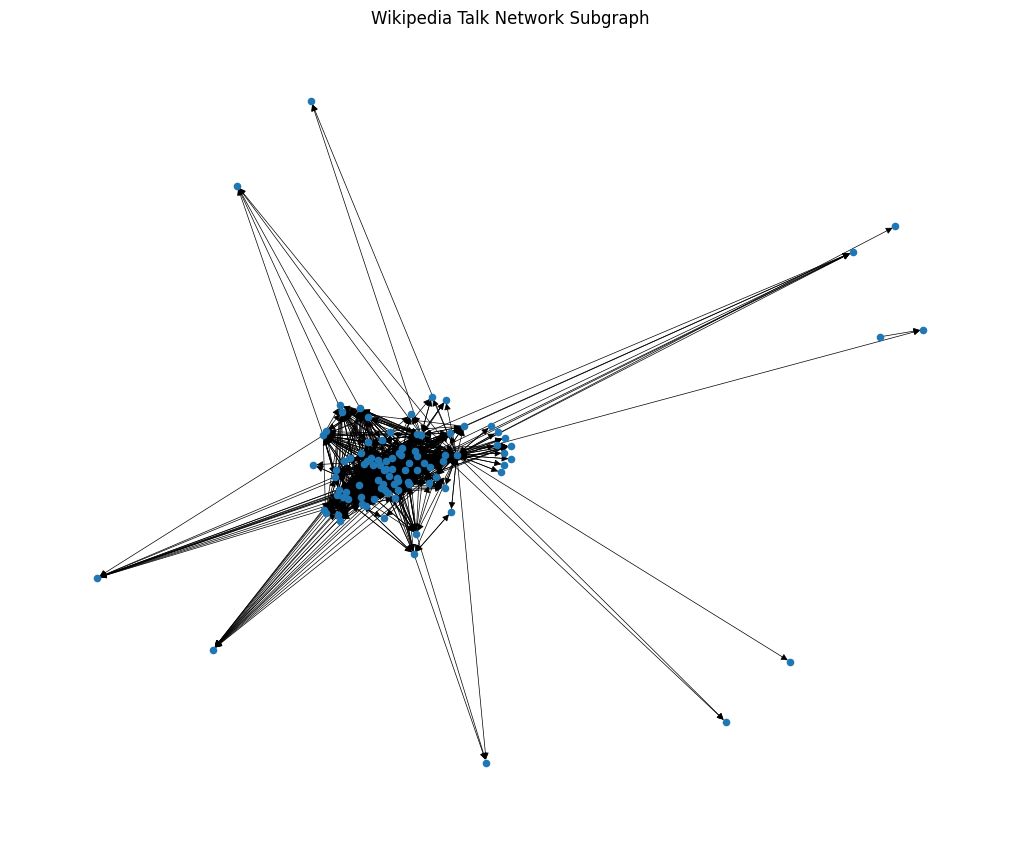

In [ ]:
# Visualize subgraph
import matplotlib.pyplot as plt
subgraph = nx.subgraph(G, list(G.nodes())[:100])
pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos, node_size=20, with_labels=False, width=0.5)
plt.title("Wikipedia Talk Network Subgraph")
plt.show()

# Graph into Neo4j - Connect to Neo4j AuraDB

In [ ]:
from py2neo import Graph
neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

# NetworkX graph into Neo4j
for source, target in G.edges():
    graph_db.run(
        """
        MERGE (a:User {id: $source})
        MERGE (b:User {id: $target})
        MERGE (a)-[:TALKS_TO]->(b)
        """,
        source=source,
        target=target
    )
print("Graph loaded into Neo4j!")

# Complete Code : batch loading - Load graph in batches

In [ ]:

!wget https://snap.stanford.edu/data/wiki-Talk.txt.gz

import pandas as pd
import networkx as nx
from py2neo import Graph


# Loading dataset into Pandas DataFrame
wiki_talk = pd.read_csv(
    "./wiki-Talk.txt.gz",
    compression="gzip",
    sep="\t",
    names=["source", "target"],
    skiprows=4  # Skip the header lines
)

# directed graph in NetworkX
G = nx.from_pandas_edgelist(wiki_talk, "source", "target", create_using=nx.DiGraph)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Step 4: Load Graph into Neo4j in Batches

# Neo4j AuraDB connection
neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

batch_size = 10000
edges = list(G.edges())

# loading batch of edges into Neo4j
def load_batch_into_neo4j(edges_batch):
    tx = graph_db.begin()
    for source, target in edges_batch:
        tx.run(
            """
            MERGE (a:User {id: $source})
            MERGE (b:User {id: $target})
            MERGE (a)-[:TALKS_TO]->(b)
            """,
            source=source,
            target=target
        )
    graph_db.commit(tx)

# Load edges in batches
for i in range(0, len(edges), batch_size):
    batch = edges[i:i + batch_size]
    load_batch_into_neo4j(batch)
    print(f"Loaded batch {i // batch_size + 1} of {len(edges) // batch_size + 1}")

print("Graph loaded into Neo4j!")

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

wiki_talk = pd.read_csv(
    "./wiki-Talk.txt.gz",
    compression="gzip",
    sep="\t",
    names=["source", "target"],
    skiprows=4  # Skip the header lines
)

G = nx.from_pandas_edgelist(wiki_talk, "source", "target", create_using=nx.DiGraph)


sample_size = 100
nodes_sample = list(G.nodes())[:sample_size]
subgraph = G.subgraph(nodes_sample)

# Visualize the Subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for positioning nodes
nx.draw(
    subgraph,
    pos,
    node_size=50,
    with_labels=True,
    font_size=8,
    font_color="black",
    edge_color="gray",
    width=0.5,
    alpha=0.8
)
plt.title("Sample Visualization of Wikipedia Talk Network")
plt.show()

In [ ]:
!wget https://snap.stanford.edu/data/wiki-Talk.txt.gz

import pandas as pd
import networkx as nx
from py2neo import Graph


wiki_talk = pd.read_csv(
    "./wiki-Talk.txt.gz",
    compression="gzip",
    sep="\t",
    names=["source", "target"],
    skiprows=4  # Skip the header lines
)

subset_size = 10000
wiki_talk_subset = wiki_talk.head(subset_size)
G = nx.from_pandas_edgelist(wiki_talk_subset, "source", "target", create_using=nx.DiGraph)
print(f"Number of nodes in subset: {G.number_of_nodes()}")
print(f"Number of edges in subset: {G.number_of_edges()}")



neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

batch_size = 1000
edges = list(G.edges())

def load_batch_into_neo4j(edges_batch):
    tx = graph_db.begin()
    for source, target in edges_batch:
        tx.run(
            """
            MERGE (a:User {id: $source})
            MERGE (b:User {id: $target})
            MERGE (a)-[:TALKS_TO]->(b)
            """,
            source=source,
            target=target
        )
    graph_db.commit(tx)

for i in range(0, len(edges), batch_size):
    batch = edges[i:i + batch_size]
    load_batch_into_neo4j(batch)
    print(f"Loaded batch {i // batch_size + 1} of {len(edges) // batch_size + 1}")

print("Subset of the graph loaded into Neo4j!")

In [ ]:
import matplotlib.pyplot as plt
subgraph = nx.subgraph(G, list(G.nodes())[:100])
pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos, node_size=20, with_labels=False, width=0.5)
plt.title("Wikipedia Talk Network Subgraph")
plt.show()

In [ ]:
!pip install langchain langgraph gradio
!pip install -U langchain-community neo4j
!pip huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 23.1 MB/s eta 0:00:00
  Attempting

# Agentic Application - LangChain and LangGraph

In [ ]:

# Step 2: Set the Hugging Face Hub API Token
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

# Step 3: Connect to Neo4j and Load the Graph into NetworkX
from py2neo import Graph
import networkx as nx
from langchain.graphs import NetworkxEntityGraph

# Connect to Neo4j
neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Query Neo4j to get nodes and edges
query = """
MATCH (a)-[r]->(b)
RETURN a.id AS source, b.id AS target
"""
result = graph_db.run(query)

# Create a NetworkX graph
G = nx.DiGraph()
for record in result:
    G.add_edge(record["source"], record["target"])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Wrap the NetworkX graph in a NetworkxEntityGraph
networkx_entity_graph = NetworkxEntityGraph(G)

# Step 4: Set Up LangChain and LangGraph
from langchain.chains import GraphQAChain
from langchain.llms import HuggingFaceHub
from langchain.agents import Tool, initialize_agent
from langchain.tools import tool  # Import the tool decorator
from langgraph.prebuilt import create_react_agent
import gradio as gr

# Initialize the HuggingFaceHub model
llm = HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs={"temperature": 0})

# Create the GraphQAChain
graph_qa_chain = GraphQAChain.from_llm(llm, graph=networkx_entity_graph, verbose=True)

# Step 5: Define Tools for the Agent
@tool
def graph_qa_tool(query: str):
    """Use this tool to answer questions about the Wikipedia Talk Network."""
    if "how many edges" in query.lower():
        return f"The graph has {G.number_of_edges()} edges."
    elif "how many nodes" in query.lower():
        return f"The graph has {G.number_of_nodes()} nodes."
    else:
        return graph_qa_chain.run(query)

@tool
def cugraph_analysis_tool(query: str):
    """Use this tool for GPU-accelerated graph analytics using cuGraph."""
    # Example: Perform PageRank using cuGraph
    import cugraph as cg
    import cudf

    # Convert NetworkX graph to cuGraph
    edges = cudf.DataFrame(list(G.edges()), columns=["source", "target"])
    G_cugraph = cg.Graph()
    G_cugraph.from_cudf_edgelist(edges, source="source", destination="target")

    # Perform PageRank
    pagerank = cg.pagerank(G_cugraph)
    return f"PageRank results: {pagerank.to_pandas().head()}"

# Step 6: Create the Agent
tools = [graph_qa_tool, cugraph_analysis_tool]
agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True,
    handle_parsing_errors=True  # Enable parsing error handling
)

def query_graph(query):
    return agent.run(query)

# Step 7: Launch the Gradio Interface
interface = gr.Interface(
    fn=query_graph,
    inputs="text",
    outputs="text",
    title="Wikipedia Talk Network Analyzer",
    description="Ask questions about the Wikipedia Talk Network or perform GPU-accelerated graph analytics."
)

# Launch the interface inline in Kaggle
interface.launch(inline=True)

# Error - Observation: Invalid Format: Missing 'Action:' after 'Thought:
  ### Solution : Ensure the agent's prompt explicitly instructs the LLM to follow the ReAct format. For example, the prompt should include instructions like:"Always start with Thought: to describe your reasoning." , "Always use Action: to specify the tool to use." , "Always use Action Input: to provide the input for the tool."

In [ ]:
import os
from langchain.chains import GraphQAChain
from langchain.llms import HuggingFaceHub
from langchain.agents import Tool, initialize_agent
from langchain.tools import tool  # Import the tool decorator
from langgraph.prebuilt import create_react_agent
import gradio as gr
from py2neo import Graph
import networkx as nx
from langchain.graphs import NetworkxEntityGraph
import cugraph as cg
import cudf
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""



neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

query = """
MATCH (a)-[r]->(b)
RETURN a.id AS source, b.id AS target
"""
result = graph_db.run(query)

# Create a NetworkX graph
G = nx.DiGraph()
for record in result:
    G.add_edge(record["source"], record["target"])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Wrap NetworkX graph in a NetworkxEntityGraph
networkx_entity_graph = NetworkxEntityGraph(G)

# Initialize HuggingFaceHub model
llm = HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs={"temperature": 0})

# Create GraphQAChain
graph_qa_chain = GraphQAChain.from_llm(llm, graph=networkx_entity_graph, verbose=True)

# Tools for Agent
@tool
def graph_qa_tool(query: str):
    """Use this tool to answer questions about the Wikipedia Talk Network."""
    if "how many edges" in query.lower():
        return f"The graph has {G.number_of_edges()} edges."
    elif "how many nodes" in query.lower():
        return f"The graph has {G.number_of_nodes()} nodes."
    else:
        return graph_qa_chain.run(query)

@tool
def cugraph_analysis_tool(query: str):
    """Use this tool for GPU-accelerated graph analytics using cuGraph."""
    # PageRank using cuGraph

    # Convert NetworkX graph to cuGraph
    edges = cudf.DataFrame(list(G.edges()), columns=["source", "target"])
    G_cugraph = cg.Graph()
    G_cugraph.from_cudf_edgelist(edges, source="source", destination="target")

    # Perform PageRank
    pagerank = cg.pagerank(G_cugraph)
    return f"PageRank results: {pagerank.to_pandas().head()}"

# Agent
tools = [graph_qa_tool, cugraph_analysis_tool]
agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True,
    handle_parsing_errors=True,  # Enable parsing error handling
    max_iterations=10
)

def query_graph(query):
    return agent.run(query)

# Gradio Interface
interface = gr.Interface(
    fn=query_graph,
    inputs="text",
    outputs="text",
    title="Wikipedia Talk Network Analyzer",
    description="Ask questions about the Wikipedia Talk Network or perform GPU-accelerated graph analytics."
)

# Interface inline in Kaggle
interface.launch(inline=True)

Number of nodes: 24854
Number of edges: 30656
* Running on local URL:  http://127.0.0.1:7863
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://5fbcf8b5560ce886a0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

> Finished chain.


In [ ]:

import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""
from py2neo import Graph
import networkx as nx
from langchain.graphs import NetworkxEntityGraph
from langchain.chains import GraphQAChain
from langchain.llms import HuggingFaceHub
from langchain.agents import Tool, initialize_agent
from langchain.tools import tool  # Import the tool decorator
from langchain.prompts import PromptTemplate
from langgraph.prebuilt import create_react_agent
import gradio as gr

# Connect to Neo4j
neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

query = """
MATCH (a)-[r]->(b)
RETURN a.id AS source, b.id AS target
"""
result = graph_db.run(query)

G = nx.DiGraph()
for record in result:
    G.add_edge(record["source"], record["target"])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

networkx_entity_graph = NetworkxEntityGraph(G)


llm = HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs={"temperature": 0})

graph_qa_chain = GraphQAChain.from_llm(llm, graph=networkx_entity_graph, verbose=True)

@tool
def graph_qa_tool(query: str):
    """Use this tool to answer questions about the Wikipedia Talk Network."""
    try:
        if "how many edges" in query.lower():
            return f"Observation: The graph has {G.number_of_edges()} edges."
        elif "how many nodes" in query.lower():
            return f"Observation: The graph has {G.number_of_nodes()} nodes."
        else:
            result = graph_qa_chain.run(query)
            return f"Observation: {result}"
    except Exception as e:
        return f"Observation: Error in graph_qa_tool: {e}"

@tool
def cugraph_analysis_tool(query: str):
    """Use this tool for GPU-accelerated graph analytics using cuGraph."""
    try:
        if "pagerank" in query.lower():
            import cugraph as cg
            import cudf

            edges = cudf.DataFrame(list(G.edges()), columns=["source", "target"])
            G_cugraph = cg.Graph()
            G_cugraph.from_cudf_edgelist(edges, source="source", destination="target")

            pagerank = cg.pagerank(G_cugraph)
            return f"Observation: PageRank results: {pagerank.to_pandas().head()}"
        else:
            return "Observation: Invalid query for cuGraph analysis."
    except Exception as e:
        return f"Observation: Error in cugraph_analysis_tool: {e}"

# Custom ReAct Prompt
react_prompt = PromptTemplate(
    input_variables=["input", "agent_scratchpad"],
    template="""
    Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    {agent_scratchpad}
    """
)

# Agent
tools = [graph_qa_tool, cugraph_analysis_tool]
agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True,
    handle_parsing_errors=True,
    agent_kwargs={"prompt": react_prompt}  # Use the custom prompt
)

def query_graph(query):
    try:
        result = agent.run(query)
        return result
    except Exception as e:
        print(f"Error: {e}")
        return f"An error occurred: {e}"

# Gradio Interface
interface = gr.Interface(
    fn=query_graph,
    inputs="text",
    outputs="text",
    title="Wikipedia Talk Network Analyzer",
    description="Ask questions about the Wikipedia Talk Network or perform GPU-accelerated graph analytics."
)

# interface inline in Kaggle
interface.launch(inline=True)

Number of nodes: 24854
Number of edges: 30656
* Running on local URL:  http://127.0.0.1:7865
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6343e82d5c40f7440c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...
Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_

Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool]
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_

Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_

Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_

Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_


Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:Answer: [graph_qa_tool, cugraph_analysis_tool] Observ
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought:

> Finished chain.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
from py2neo import Graph
import networkx as nx
from langchain.graphs import NetworkxEntityGraph
from langchain.chains import GraphQAChain
from langchain.llms import OpenAI
from langchain.agents import Tool, initialize_agent
from langchain.tools import tool  # Import the tool decorator
from langchain.prompts import PromptTemplate
from langgraph.prebuilt import create_react_agent
import gradio as gr
import cugraph as cg
import cudf

# Connect to Neo4j
neo4j_uri = "bolt://<your-aura-db-uri>:7687"  # Replace with Neo4j AuraDB URI
neo4j_user = "<your-username>"               # Replace with  Neo4j username
neo4j_password = "<your-password>"           # Replace with Neo4j password
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))
graph_db = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Query Neo4j to get nodes and edges
query = """
MATCH (a)-[r]->(b)
RETURN a.id AS source, b.id AS target
"""
result = graph_db.run(query)


G = nx.DiGraph()
for record in result:
    G.add_edge(record["source"], record["target"])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

networkx_entity_graph = NetworkxEntityGraph(G)


# OpenAI model
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)  # GPT-3.5 Turbo

# GraphQAChain
graph_qa_chain = GraphQAChain.from_llm(llm, graph=networkx_entity_graph, verbose=True)

# Tools for Agent
@tool
def graph_qa_tool(query: str):
    """Use this tool to answer questions about the Wikipedia Talk Network."""
    try:
        if "how many edges" in query.lower():
            return f"Observation: The graph has {G.number_of_edges()} edges."
        elif "how many nodes" in query.lower():
            return f"Observation: The graph has {G.number_of_nodes()} nodes."
        else:
            result = graph_qa_chain.run(query)
            return f"Observation: {result}"
    except Exception as e:
        return f"Observation: Error in graph_qa_tool: {e}"

@tool
def cugraph_analysis_tool(query: str):
    """Use this tool for GPU-accelerated graph analytics using cuGraph."""
    try:
        if "pagerank" in query.lower():


            # NetworkX graph to cuGraph
            edges = cudf.DataFrame(list(G.edges()), columns=["source", "target"])
            G_cugraph = cg.Graph()
            G_cugraph.from_cudf_edgelist(edges, source="source", destination="target")

            # PageRank
            pagerank = cg.pagerank(G_cugraph)
            return f"Observation: PageRank results: {pagerank.to_pandas().head()}"
        else:
            return "Observation: Invalid query for cuGraph analysis."
    except Exception as e:
        return f"Observation: Error in cugraph_analysis_tool: {e}"

# Custom ReAct Prompt
react_prompt = PromptTemplate(
    input_variables=["input", "agent_scratchpad"],
    template="""
    Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    {agent_scratchpad}
    """
)

# Agent
tools = [graph_qa_tool, cugraph_analysis_tool]
agent = initialize_agent(
    tools,
    llm,
    agent="zero-shot-react-description",
    verbose=True,
    handle_parsing_errors=True,
    agent_kwargs={"prompt": react_prompt}  # Custom prompt
)

def query_graph(query):
    try:
        result = agent.run(query)
        return result
    except Exception as e:
        print(f"Error: {e}")
        return f"An error occurred: {e}"

# Gradio Interface
interface = gr.Interface(
    fn=query_graph,
    inputs="text",
    outputs="text",
    title="Wikipedia Talk Network Analyzer",
    description="Ask questions about the Wikipedia Talk Network or perform GPU-accelerated graph analytics."
)

# Gradio interface inline in Kaggle
interface.launch(inline=True)

Number of nodes: 24854
Number of edges: 30656


<ipython-input-24-e65d23f6ade5>:44: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)  # Use GPT-3.5 Turbo


* Running on local URL:  http://127.0.0.1:7866
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://46360a240a3aa7c371.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...
Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
